
# <span style="color:rgb(213,80,0)">Evlaución de las capacidades de robot Scara</span>

Cabrera Cruz Carlo Alejandro


Gutiérrez Espriella Moisés Ariel


González Martínez Roberto Carlos


Rodriguez Torres Angel Adrian

## Resumen

En el presente proyecto se evalúan las capacidades cinemáticas y dinámicas de un robot manipulador tipo SCARA mediante el diseño, simulación y análisis de una tarea de seguimiento de trayectoria. El objetivo principal es validar si el robot es capaz de ejecutar una maniobra de "pick\-and\-place" diagonal de manera eficiente, evitando singularidades y movimientos bruscos.


Para ello, se propuso una trayectoria transversal en el espacio de trabajo que conecta dos puntos operativos clave, interpolando el movimiento mediante un perfil de velocidad polinómico de quinto grado. Se desarrolló un modelo matemático en MATLAB para resolver la cinemática inversa y predecir el comportamiento articular (posición, velocidad y aceleración), así como para evaluar la manipulabilidad del mecanismo a lo largo de la ruta.


Posteriormente, los resultados teóricos fueron validados experimentalmente mediante una simulación física en el entorno ROS 2 (Robot Operating System) y Gazebo. La comparación entre los datos calculados y la respuesta real del robot demostró la viabilidad de la trayectoria propuesta y la eficacia del controlador implementado, confirmando la hipótesis de que una planificación adecuada en el espacio de trabajo permite optimizar el desempeño del manipulador.

## Defición de la tarea

El robot debe lleva su efector final de un punto a un punto


La tarea asignada al robot consiste en una operación de manipulación de material (*pick\-and\-place*) que requiere trasladar el efector final desde una zona de recogida lateral hasta una zona de depósito frontal, cruzando el plano de trabajo del robot.


Se seleccionó una **Trayectoria Transversal Diagonal** en lugar de un movimiento simple sobre un solo eje, con el fin de evaluar la capacidad del robot para coordinar simultáneamente sus dos articulaciones principales (hombro y codo) bajo condiciones de velocidad variable.


**Parámetros de la Tarea:**

-  **Tipo de Movimiento:** Interpolación lineal en el espacio Cartesiano (Línea recta del punto A al B).
-  **Duración (****t\_f****):** 6.0 segundos.
-  **Perfil de Velocidad:** Polinomio de quinto grado (garantiza velocidad y aceleración nula al inicio y al final).

**Puntos de Control (Coordenadas en metros y radianes):**

1.  **Punto Inicial (Pick):**

-  Posición: x = 0.5 m, y = \-0.4 m.
-  Orientación de la herramienta: theta = \-30° (\-0.5236 rad).
-  *Justificación:* Ubicado en el cuadrante IV, representa una posición de recogida típica a la derecha del robot.

1.  **Punto Final (Place):**

-  Posición: x = 0.6 m, y = 0.3 m.
-  Orientación de la herramienta: theta = +30° (+0.5236 rad).
-  *Justificación:* Ubicado en el cuadrante I, representa una posición de depósito extendida hacia la izquierda y al frente.

Esta trayectoria fue diseñada estratégicamente para mantenerse dentro del radio de alcance máximo del robot (R\_max = L\_1 + L\_2 = 0.90 m) y lejos de la singularidad del origen (R\_min approx 0), asegurando así la operación segura del mecanismo.



In [1]:
% --- DEFINICIÓN DE LA TAREA: TRAYECTORIA TRANSVERSAL ---
% Punto Inicial (Pick Zone - Derecha)
x_in = 0.5;
y_in = -0.4;
theta_in = -30 * (pi/180); % Orientación inicial (-0.52 rad)

% Punto Final (Place Zone - Izquierda)
x_fin = 0.6;
y_fin = 0.3;
theta_fin = 30 * (pi/180); % Orientación final (0.52 rad)


### Definición de la tarea en el espacio de las juntas

Para clacular la planeación de movimientos en el espacio de las juntas se requiere caluleos la postura en punto inicial y en punto final.


Para ejecutar la trayectoria cartesiana definida anteriormente, es necesario transformar las coordenadas (x, y, theta) del espacio de trabajo a coordenadas articulares (q\_1, q\_2, q\_3) que los motores del robot puedan interpretar.



In [2]:
% Cálculo de la solución de la primer postura

% Definición de los parámetros del robot (en base a la descripción de
% nuestrio archivo "scara.urdf"
L1 = 0.45; % Longitud del primer eslabón
L2 = 0.45; % Longitud del segundo eslabón
L3 = 0.25; % Longitud del tercer eslabón

% Planteamiento de la solucion

x_3 = x_in - L3*cos(theta_in);
y_3 = y_in - L3*sin(theta_in);

% Solucion por le metodo geometrico

theta_2_in = acos((x_3^2+y_3^2-L1^2-L2^2)/(2*L1*L2));

beta = atan2(y_3,x_3);

psi = acos((x_3^2+y_3^2+L1^2-L2^2)/(2*L1*sqrt(x_3^2+y_3^2)));

theta_1_in = beta + psi;

% theta_1_in = beta - psi

theta_3_in = theta_in -theta_1_in - theta_2_in;

%%%
%% Solucion para el punto final

x_3 = x_fin - L3*cos(theta_fin);
y_3 = y_fin - L3*sin(theta_fin);

% Solucion por le metodo geometrico

theta_2_fin = acos((x_3^2+y_3^2-L1^2-L2^2)/(2*L1*L2));

beta = atan2(y_3,x_3);

psi = acos((x_3^2+y_3^2+L1^2-L2^2)/(2*L1*sqrt(x_3^2+y_3^2)));

theta_1_fin = beta + psi;

% theta_1_fin = beta - psi

theta_3_fin = theta_fin -theta_1_fin - theta_2_fin;



## Plateamiento de una trayectoria en el espacio de las juntas del robot

Definición de la trayectoria


$$q =q_i +\lambda \left(t\right)\left(q_{\textrm{fin}} -q_{\textrm{in}} \right)$$

Una vez obtenidos los vectores de configuración inicial (q\_ini) y final (q\_fin) mediante la cinemática inversa, el siguiente paso es definir la función temporal que gobernará la transición entre estos estados.


Este enfoque genera un movimiento coordinado donde todas las articulaciones inician y terminan simultáneamente, aunque la trayectoria resultante del efector final en el espacio cartesiano será una curva compleja, no necesariamente una línea recta.



In [3]:
tf = 6;


for i=1:tf+1
    t = i; % Increment time for the next iteration
    theta_1_P(i) = theta_1_in + ((10/tf^3)*t^3 - (15/tf^4)*t^4 + (6/tf^5)*t^5)*(theta_1_fin-theta_1_in);
    theta_2_P(i) = theta_2_in + ((10/tf^3)*t^3 - (15/tf^4)*t^4 + (6/tf^5)*t^5)*(theta_2_fin-theta_2_in);
    theta_3_P(i) = theta_3_in + ((10/tf^3)*t^3 - (15/tf^4)*t^4 + (6/tf^5)*t^5)*(theta_3_fin-theta_3_in);

end



## Planeación de trayectoria en el espacio de trabajo del robot

Dado que la tarea de "pick\-and\-place" requiere precisión espacial para evitar colisiones con posibles obstáculos en el entorno, se optó por una estrategia de planificación directa en el **Espacio de Trabajo (Cartesiano)**. A diferencia del método articular, este enfoque garantiza que el efector final describa una **línea recta perfecta** entre los puntos de inicio y fin.



In [4]:
% Cálculo de la solución de la primer postura

% Definición de los parámetros del robot
L1 = 0.45; % Longitud del primer eslabón
L2 = 0.45; % Longitud del segundo eslabón
L3 = 0.25; % Longitud del tercer eslabón

% x_in = 0.3;
% y_in = 0.3;
% theta_in = 0;

% x_fin = 0.3;
%y_fin = -0.3;
% theta_fin = pi/2;

tf = 10;
for i=1:tf+1
    t = i;
    x_P(i) = x_in + ((10/tf^3)*t^3 - (15/tf^4)*t^4 + (6/tf^5)*t^5)*(x_fin-x_in);
    y_P(i) = y_in + ((10/tf^3)*t^3 - (15/tf^4)*t^4 + (6/tf^5)*t^5)*(y_fin-y_in);
    theta_P(i) = theta_in + ((10/tf^3)*t^3 - (15/tf^4)*t^4 + (6/tf^5)*t^5)*(theta_fin-theta_in);

    x_3_a(i) = x_P(i) - L3*cos(theta_P(i));
    y_3_a(i) = y_P(i) - L3*sin(theta_P(i));

    % Solucion por le metodo geometrico

    theta_2_tray(i) = acos((x_3_a(i)^2+y_3_a(i)^2-L1^2-L2^2)/(2*L1*L2));

    beta = atan2(y_3_a(i),x_3_a(i));

    psi = acos((x_3_a(i)^2+y_3_a(i)^2+L1^2-L2^2)/(2*L1*sqrt(x_3_a(i)^2+y_3_a(i)^2)));

    theta_1_tray(i) = beta + psi;

    % theta_1_in = beta - psi

    theta_3_tray(i) = theta_P(i) - theta_1_tray(i) - theta_2_tray(i);

end


In [5]:
tsim=0:1:tf

tsim = 1x11
     0     1     2     3     4     5     6     7     8     9    10


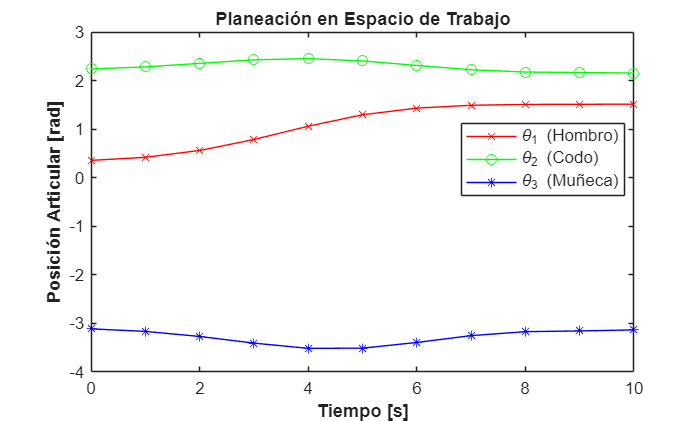

In [6]:
figure;

plot(tsim, theta_1_tray, 'r-x');
hold on;
plot(tsim, theta_2_tray, 'g-o');
plot(tsim, theta_3_tray, 'b-*');

hold off;

legend
title("Planeación en espacio de trabajo")
xlabel("t")
ylabel("rad")

% Nombres
legend({'\theta_1 (Hombro)', '\theta_2 (Codo)', '\theta_3 (Muñeca)'}, ...
    'Location', 'best', 'Interpreter', 'tex', 'FontSize', 10);

% Títulos y Ejes con formato negrita
title('Planeación en Espacio de Trabajo', 'FontWeight', 'bold', 'FontSize', 11);
xlabel('Tiempo [s]', 'FontWeight', 'bold');
ylabel('Posición Articular [rad]', 'FontWeight', 'bold');


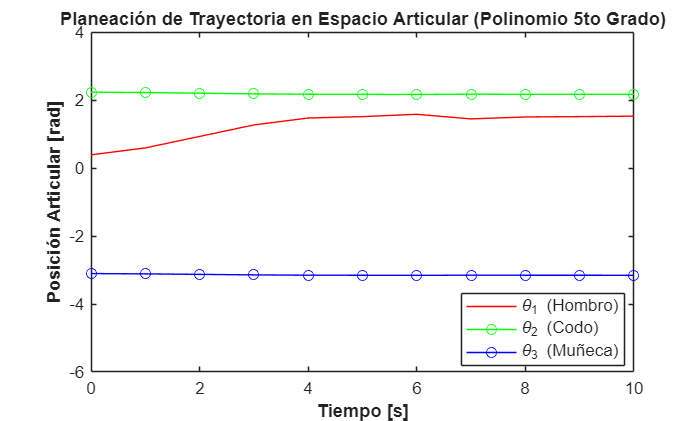

In [7]:
figure;

plot(tsim, theta_1_P, 'r-');
hold on;
plot(tsim, theta_2_P, 'g-o');
plot(tsim, theta_3_P, 'b-o');

hold off;

xlim([0.00 10.00])
ylim([-6.0 4.0])
legend
title("Planeación en el espacio articular")
xlabel("t")
ylabel("rad")

% Nombres
legend({'\theta_1 (Hombro)', '\theta_2 (Codo)', '\theta_3 (Muñeca)'}, ...
    'Location', 'best', 'Interpreter', 'tex', 'FontSize', 10);

% Títulos y Ejes
title('Planeación de Trayectoria en Espacio Articular (Polinomio 5to Grado)', ...
    'FontWeight', 'bold', 'FontSize', 11);
xlabel('Tiempo [s]', 'FontWeight', 'bold');
ylabel('Posición Articular [rad]', 'FontWeight', 'bold');

In [8]:

% w = L1*L2*sin(theta_2)

### Calculo de la cinemática de velocidades del robot

Cinemática de velocidades en espacio de las juntas


Para determinar las velocidades angulares requeridas en los motores (qdot) que satisfagan la trayectoria cartesiana de velocidad lineal (v), se empleó la relación diferencial basada en la **Matriz Jacobiana**.




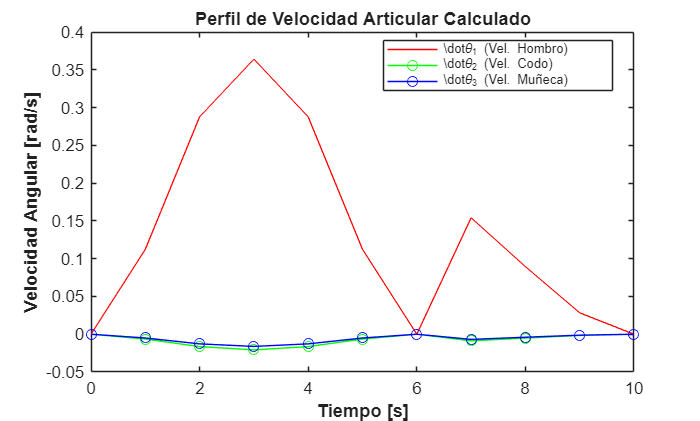

In [9]:
tf = 6;


for i=1:tf+1
    t = i-1; % Increment time for the next iteration
    theta_1_P_v(i) =  ((30/tf^3)*t^2 - (60/tf^4)*t^3 + (30/tf^5)*t^4)*(theta_1_fin-theta_1_in);
    theta_2_P_v(i) = ((30/tf^3)*t^2 - (60/tf^4)*t^3 + (30/tf^5)*t^4)*(theta_2_fin-theta_2_in);
    theta_3_P_v(i) =  ((30/tf^3)*t^2 - (60/tf^4)*t^3 + (30/tf^5)*t^4)*(theta_3_fin-theta_3_in);

end

figure;

plot(tsim, theta_1_P_v, 'r-');
hold on;
plot(tsim, theta_2_P_v, 'g-o');
plot(tsim, theta_3_P_v, 'b-o');

hold off;

% Nombres
legend({'\dot{\theta}_1 (Vel. Hombro)', '\dot{\theta}_2 (Vel. Codo)', '\dot{\theta}_3 (Vel. Muñeca)'}, ...
    'Location', 'best', 'Interpreter', 'tex', 'FontSize', 8);

% Títulos
title('Perfil de Velocidad Articular Calculado', 'FontWeight', 'bold', 'FontSize', 11);
xlabel('Tiempo [s]', 'FontWeight', 'bold');
ylabel('Velocidad Angular [rad/s]', 'FontWeight', 'bold');


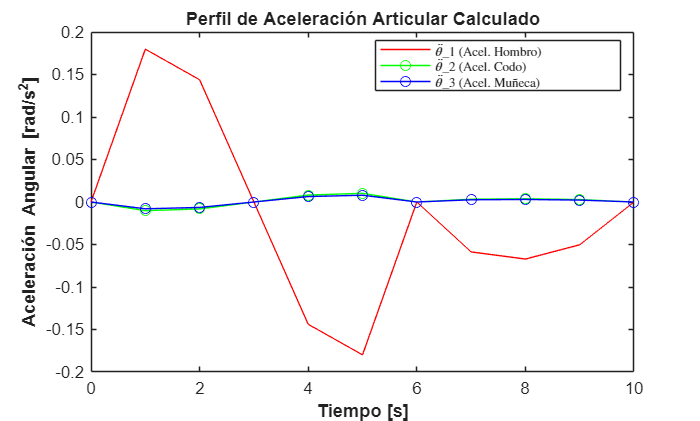

In [10]:
tf = 6;

for i=1:tf+1
    t = i-1; % Increment time for the next iteration
    theta_1_P_a(i) =  ((60/tf^3)*t - (180/tf^4)*t^2 + (120/tf^5)*t^3)*(theta_1_fin-theta_1_in);
    theta_2_P_a(i) = ((60/tf^3)*t - (180/tf^4)*t^2 + (120/tf^5)*t^3)*(theta_2_fin-theta_2_in);
    theta_3_P_a(i) =  ((60/tf^3)*t - (180/tf^4)*t^2 + (120/tf^5)*t^3)*(theta_3_fin-theta_3_in);

end

figure;

plot(tsim, theta_1_P_a, 'r-');
hold on;
plot(tsim, theta_2_P_a, 'g-o');
plot(tsim, theta_3_P_a, 'b-o');

hold off;

% Nombres
legend({'\ddot{\theta}_1 (Acel. Hombro)', '\ddot{\theta}_2 (Acel. Codo)', '\ddot{\theta}_3 (Acel. Muñeca)'}, ...
    'Location', 'best', 'Interpreter', 'latex', 'FontSize', 8);

% Títulos
title('Perfil de Aceleración Articular Calculado', 'FontWeight', 'bold', 'FontSize', 11);
xlabel('Tiempo [s]', 'FontWeight', 'bold');
ylabel('Aceleración Angular [rad/s^2]', 'FontWeight', 'bold');

## Cinemática de velocidades en espacio de trabajo

Para completar el análisis cinemático y garantizar que el robot pueda cumplir con los tiempos de ciclo requeridos, se determinaron los perfiles de velocidad articular (qdot) necesarios para generar la velocidad lineal cartesiana (v) de la trayectoria.




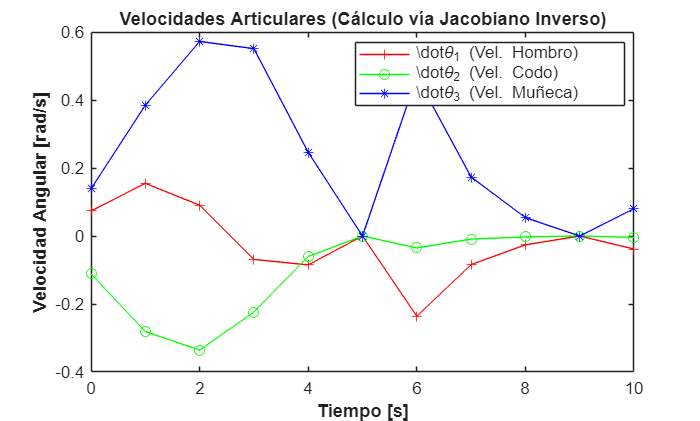

In [11]:
% Cálculo de la solución de la primer postura

% Definición de los parámetros del robot
L_1 = 0.45; % Longitud del primer eslabón
L_2 = 0.45; % Longitud del segundo eslabón
L_3 = 0.25; % Longitud del tercer eslabón

% x_in = 0.3;
% y_in = 0.3;
% theta_in = 0;

% x_fin = 0.3;
% y_fin = -0.3;
%theta_fin = pi/2;

tf = 6;
for i=1:tf+1
    t = i;
    x_P_v(i) = ((30/tf^3)*t^2 - (60/tf^4)*t^3 + (30/tf^5)*t^4)*(x_fin-x_in);
    y_P_v(i) = ((30/tf^3)*t^2 - (60/tf^4)*t^3 + (30/tf^5)*t^4)*(y_fin-y_in);
    theta_P_v(i) = ((30/tf^3)*t^2 - (60/tf^4)*t^3 + (30/tf^5)*t^4)*(theta_fin-theta_in);

    x_dot = x_P_v(i);
    y_dot = y_P_v(i);
    theta_dot_P = theta_P_v(i);

    theta_O_1 = theta_1_tray(i);
    theta_1_2 = theta_2_tray(i);
    theta_2_3 = theta_3_tray(i);

    theta_1_v(i) = (x_dot*cos(theta_1_2 + theta_O_1))/(L_1*sin(theta_1_2)) + (y_dot*sin(theta_1_2 + theta_O_1))/(L_1*sin(theta_1_2)) + (L_3*theta_dot_P*sin(theta_2_3))/(L_1*sin(theta_1_2));
    theta_2_v(i) = - (x_dot*(L_2*cos(theta_1_2 + theta_O_1) + L_1*cos(theta_O_1)))/(L_1*L_2*sin(theta_1_2)) - (y_dot*(L_2*sin(theta_1_2 + theta_O_1) + L_1*sin(theta_O_1)))/(L_1*L_2*sin(theta_1_2)) - (L_3*theta_dot_P*(L_1*sin(theta_1_2 + theta_2_3) + L_2*sin(theta_2_3)))/(L_1*L_2*sin(theta_1_2));
    theta_3_v(i) = (theta_dot_P*(L_3*sin(theta_1_2 + theta_2_3) + L_2*sin(theta_1_2)))/(L_2*sin(theta_1_2)) + (x_dot*cos(theta_O_1))/(L_2*sin(theta_1_2)) + (y_dot*sin(theta_O_1))/(L_2*sin(theta_1_2));


end

figure;

plot(tsim, theta_1_v, 'r-+');
hold on;
plot(tsim, theta_2_v, 'g-o');
plot(tsim, theta_3_v, 'b-*');

hold off;

legend({'\dot{\theta}_1 (Vel. Hombro)', '\dot{\theta}_2 (Vel. Codo)', '\dot{\theta}_3 (Vel. Muñeca)'}, ...
    'Location', 'best', 'Interpreter', 'tex', 'FontSize', 10);

title('Velocidades Articulares (Cálculo vía Jacobiano Inverso)', 'FontWeight', 'bold', 'FontSize', 11);
xlabel('Tiempo [s]', 'FontWeight', 'bold');
ylabel('Velocidad Angular [rad/s]', 'FontWeight', 'bold');


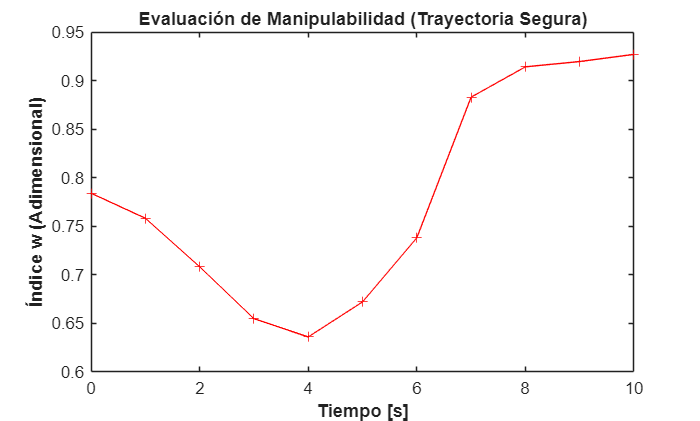

In [12]:
for i=1:tf+1

    w(i) = L_1*L_2*sin(theta_2_tray(i))/(L1*L_2);

end

figure;
plot(tsim, w , 'r-+');

xlabel("t")
ylabel("w")

title('Evaluación de Manipulabilidad (Trayectoria Segura)', 'FontWeight', 'bold', 'FontSize', 11);
xlabel('Tiempo [s]', 'FontWeight', 'bold');
ylabel('Índice w (Adimensional)', 'FontWeight', 'bold');

## Evalaución de la capacidad del robot
 $ $ \begin{array}{l} \left(\begin{array}{c} {\ddot{\theta} }_{O,1} \,{\left(\frac{\cos \left(\theta_{1,2} \right)}{4}+\frac{{\sigma_{12} }^2 }{2}+\frac{{\sigma_{14} }^2 }{2}+\frac{27}{8}\right)}-{\dot{\theta} }_{2,3} \,{\left(\frac{\sigma_{18} \,\sigma_{10} }{16}-\frac{\sigma_{16} \,\sigma_{11} }{16}+\frac{\sigma_{12} \,\sigma_4 }{2}-\frac{\sigma_5 \,\sigma_{14} }{2}\right)}+{\ddot{\theta} }_{1,2} \,\sigma_3 +{\ddot{\theta} }_{2,3} \,\sigma_6 -{\dot{\theta} }_{1,2} \,{\left(\sigma_8 -\frac{\sigma_{14} \,\sigma_2 }{2}+\frac{\sigma_1 \,\sigma_{12} }{2}-\sigma_9 +\frac{{\dot{\theta} }_{1,2} \,\sin \left(\theta_{1,2} \right)}{8}+\frac{{\dot{\theta} }_{O,1} \,\sin \left(\theta_{1,2} \right)}{4}\right)}\newline \frac{{{\dot{\theta} }_{O,1} }^2 \,\sin \left(\theta_{1,2} \right)}{8}-{\dot{\theta} }_{2,3} \,{\left(\frac{\sigma_{18} \,\sigma_{10} }{16}-\frac{{\left(\frac{\sigma_{18} }{8}+\sigma_{19} \right)}\,\sigma_5 }{2}+\frac{{\left(\frac{\sigma_{16} }{8}+\sigma_{17} \right)}\,\sigma_4 }{2}-\frac{\sigma_{16} \,\sigma_{11} }{16}\right)}+{\ddot{\theta} }_{2,3} \,\sigma_7 +\frac{\sigma_{10} \,\sigma_1 }{2}+{\ddot{\theta} }_{O,1} \,\sigma_3 -\frac{\sigma_{11} \,\sigma_2 }{2}+{\ddot{\theta} }_{1,2} \,{\left(\frac{{{\left(\frac{\sigma_{16} }{8}+\sigma_{17} \right)}}^2 }{2}+\frac{{{\left(\frac{\sigma_{18} }{8}+\sigma_{19} \right)}}^2 }{2}+\frac{33}{16}\right)}-{\dot{\theta} }_{1,2} \,{\left(\frac{{\left(\frac{\sigma_{16} }{8}+\sigma_{17} \right)}\,\sigma_1 }{2}-\frac{{\left(\frac{\sigma_{18} }{8}+\sigma_{19} \right)}\,\sigma_2 }{2}+\sigma_8 -\sigma_9 +\frac{{\dot{\theta} }_{O,1} \,\sin \left(\theta_{1,2} \right)}{8}\right)}+\frac{{\dot{\theta} }_{1,2} \,{\dot{\theta} }_{O,1} \,\sin \left(\theta_{1,2} \right)}{8}\newline {\ddot{\theta} }_{2,3} \,{\left(\frac{{\sigma_{16} }^2 }{128}+\frac{{\sigma_{18} }^2 }{128}+1\right)}-\frac{\sigma_5 \,\sigma_{11} }{2}+{\ddot{\theta} }_{1,2} \,\sigma_7 -{\dot{\theta} }_{2,3} \,{\left(\frac{\sigma_{18} \,\sigma_{10} }{16}-\frac{\sigma_{18} \,\sigma_5 }{16}-\frac{\sigma_{16} \,\sigma_{11} }{16}+\frac{\sigma_{16} \,\sigma_4 }{16}\right)}+{\dot{\theta} }_{1,2} \,{\left(\frac{\sigma_{18} \,\sigma_2 }{16}-\frac{\sigma_{18} \,\sigma_{10} }{16}-\frac{\sigma_{16} \,\sigma_1 }{16}+\frac{\sigma_{16} \,\sigma_{11} }{16}\right)}+{\ddot{\theta} }_{O,1} \,\sigma_6 +\frac{\sigma_{10} \,\sigma_4 }{2} \end{array}\right)\\
\mathrm{}\\
\textrm{where}\\
\mathrm{}\\
\;\;\sigma_1 =\frac{{\dot{\theta} }_{2,3} \,\sigma_{18} }{8}+\sigma_{15} +{\dot{\theta} }_{O,1} \,{\left(\frac{\sigma_{18} }{8}+\sigma_{19} \right)}\\
\mathrm{}\\
\;\;\sigma_2 =\sigma_{13} +{\dot{\theta} }_{O,1} \,{\left(\frac{\sigma_{16} }{8}+\sigma_{17} \right)}+\frac{{\dot{\theta} }_{2,3} \,\sigma_{16} }{8}\\
\mathrm{}\\
\;\;\sigma_3 =\frac{\cos \left(\theta_{1,2} \right)}{8}+\frac{{\left(\frac{\sigma_{16} }{8}+\sigma_{17} \right)}\,\sigma_{12} }{2}+\frac{{\left(\frac{\sigma_{18} }{8}+\sigma_{19} \right)}\,\sigma_{14} }{2}+\frac{33}{16}\\
\mathrm{}\\
\;\;\sigma_4 =\frac{{\dot{\theta} }_{1,2} \,\sigma_{18} }{8}+\frac{{\dot{\theta} }_{2,3} \,\sigma_{18} }{8}+\frac{{\dot{\theta} }_{O,1} \,\sigma_{18} }{8}\\
\mathrm{}\\
\;\;\sigma_5 =\frac{{\dot{\theta} }_{1,2} \,\sigma_{16} }{8}+\frac{{\dot{\theta} }_{2,3} \,\sigma_{16} }{8}+\frac{{\dot{\theta} }_{O,1} \,\sigma_{16} }{8}\\
\mathrm{}\\
\;\;\sigma_6 =\frac{\sigma_{16} \,\sigma_{12} }{16}+\frac{\sigma_{18} \,\sigma_{14} }{16}+1\\
\mathrm{}\\
\;\;\sigma_7 =\frac{\sigma_{16} \,{\left(\frac{\sigma_{16} }{8}+\sigma_{17} \right)}}{16}+\frac{\sigma_{18} \,{\left(\frac{\sigma_{18} }{8}+\sigma_{19} \right)}}{16}+1\\
\mathrm{}\\
\;\;\sigma_8 =\frac{{\left(\frac{\sigma_{18} }{8}+\sigma_{19} \right)}\,\sigma_{10} }{2}\\
\mathrm{}\\
\;\;\sigma_9 =\frac{{\left(\frac{\sigma_{16} }{8}+\sigma_{17} \right)}\,\sigma_{11} }{2}\\
\mathrm{}\\
\;\;\sigma_{10} =\sigma_{13} +\frac{{\dot{\theta} }_{2,3} \,\sigma_{16} }{8}+{\dot{\theta} }_{O,1} \,\sigma_{12} \\
\mathrm{}\\
\;\;\sigma_{11} =\frac{{\dot{\theta} }_{2,3} \,\sigma_{18} }{8}+{\dot{\theta} }_{O,1} \,\sigma_{14} +\sigma_{15} \\
\mathrm{}\\
\;\;\sigma_{12} =\frac{\sigma_{16} }{8}+\sigma_{17} +\frac{\cos \left(\theta_{O,1} \right)}{2}\\
\mathrm{}\\
\;\;\sigma_{13} ={\dot{\theta} }_{1,2} \,{\left(\frac{\sigma_{16} }{8}+\sigma_{17} \right)}\\
\mathrm{}\\
\;\;\sigma_{14} =\frac{\sigma_{18} }{8}+\sigma_{19} +\frac{\sin \left(\theta_{O,1} \right)}{2}\\
\mathrm{}\\
\;\;\sigma_{15} ={\dot{\theta} }_{1,2} \,{\left(\frac{\sigma_{18} }{8}+\sigma_{19} \right)}\\
\mathrm{}\\
\;\;\sigma_{16} =\cos \left(\theta_{1,2} +\theta_{2,3} +\theta_{O,1} \right)\\
\mathrm{}\\
\;\;\sigma_{17} =\frac{\cos \left(\theta_{1,2} +\theta_{O,1} \right)}{2}\\
\mathrm{}\\
\;\;\sigma_{18} =\sin \left(\theta_{1,2} +\theta_{2,3} +\theta_{O,1} \right)\\
\mathrm{}\\
\;\;\sigma_{19} =\frac{\sin \left(\theta_{1,2} +\theta_{O,1} \right)}{2}
\end{array} $ $

## Cálculo de los pares del robot

Para estimar los requerimientos de fuerza (par motor) necesarios para que cada actuador ejecute la trayectoria planificada, se implementó el **Modelo Dinámico Inverso** utilizando la formulación energética de **Euler\-Lagrange**.



In [13]:

for i=1:tf+1

    theta_1 = theta_1_P(i);
    theta_2 = theta_2_P(i);
    theta_3 = theta_3_P(i);

    theta_1_vc = theta_1_P_v(i);
    theta_2_vc = theta_2_P_v(i);
    theta_3_vc = theta_3_P_v(i);

    theta_1_a = theta_1_P_a(i);
    theta_2_a = theta_2_P_a(i);
    theta_3_a = theta_3_P_a(i);

    sigma_19 = sin(theta_2+theta_1)/2;
    sigma_18 = sin(theta_1+theta_2+theta_3);
    sigma_17 = cos(theta_2+theta_1)/2;
    sigma_16 = cos(theta_1+theta_2+theta_3);

    sigma_15 = theta_2_vc*(sigma_18/8 + sigma_19);
    sigma_14 = sigma_18/8 + sigma_19 + sin(theta_1)/2;
    sigma_13 = theta_2_vc *(sigma_16/8 +sigma_17);
    sigma_12 = sigma_16/8 +sigma_17 +cos(theta_1)/2;
    sigma_11 = theta_3_vc*sigma_18/8 + theta_1_vc*sigma_14 +sigma_15;
    sigma_10 = sigma_13 + theta_3_vc*sigma_16/8 +theta_1_vc*sigma_12;
    sigma_9 = ((sigma_16/8 + sigma_17)*sigma_11)/2;
    sigma_8 = ((sigma_18/8 + sigma_19)*sigma_10)/2;
    sigma_7 = (sigma_16*(sigma_16/8 + sigma_17))/16 + (sigma_18*(sigma_18/8 + sigma_19))/16 + 1;
    sigma_6 = sigma_16*sigma_12/16 + sigma_18*sigma_14 + 1;
    sigma_5 = theta_2_vc*sigma_16/8 + theta_3_vc*sigma_16/8 + theta_1_vc*sigma_16/8;
    sigma_4 = theta_2_vc*sigma_18/8 + theta_3_vc*sigma_18/8 + theta_1_vc*sigma_18/8;
    sigma_3 = cos(theta_2)/8 + ((sigma_16/8 + sigma_17)*sigma_12)/2 + ((sigma_18/8 + sigma_19)*sigma_14)/2 + 33/16;
    sigma_2 = sigma_13 +theta_1_vc*(sigma_16/8 + sigma_17) + theta_3_vc*sigma_16/8;
    sigma_1 = theta_3_vc*sigma_18/8 + sigma_15 +theta_1_vc*(sigma_18/8 + sigma_19);

    tao_1_c(i) = theta_1_a*(cos(theta_2)/4 + sigma_12^2/2 + sigma_14^2/2 + 27/8) - theta_3_vc* (sigma_18*sigma_10/16 - sigma_16*sigma_11/16 + sigma_12*sigma_4/2 - sigma_5*sigma_14/2) + theta_2_a*sigma_3 + theta_3_a*sigma_6 - theta_2_vc*(sigma_8 - sigma_14*sigma_2/2 + sigma_1*sigma_12/2 - sigma_9 + theta_2_vc*sin(theta_2)/8 + theta_1_vc*sin(theta_2)/4);
    tao_2_c(i) = theta_1_vc^2*sin(theta_2)/8 - theta_3_vc*(sigma_18*sigma_10 - ((sigma_18/8 + sigma_19)*sigma_5)/2 + ((sigma_16/8 + sigma_17)*sigma_4)/2 - sigma_16*sigma_11/16) + theta_2_a*sigma_7 + sigma_10*sigma_1/2 + theta_1_a*sigma_3 - sigma_11*sigma_2/2 + theta_2_a*(((sigma_16 + sigma_17)^2)/2 + ((sigma_18 + sigma_19)^2)/2 + 33/16) - theta_2_vc*((sigma_16/8 + sigma_17)*sigma_1/2 + (sigma_18/8 + sigma_19)*sigma_2/2 + sigma_8 - sigma_9 + theta_1_vc*sin(theta_2)/8) + theta_2_vc*theta_1_vc*sin(theta_2)/8;
    tao_3_c(i) = theta_3_a*(sigma_16^2/128 + sigma_18^2/128 + 1 ) - sigma_5*sigma_11/2 + theta_2_a*sigma_7 - theta_3_vc*(sigma_18*sigma_10/16 - sigma_18*sigma_5/16 - sigma_16*sigma_11/16 + sigma_16*sigma_4/16) + theta_2_vc*(sigma_18*sigma_2/16 - sigma_18*sigma_10/16 - sigma_16*sigma_1/16 + sigma_16*sigma_11/16) + theta_1_a*sigma_6 + sigma_10*sigma_4/2;

    pot_1(i) = abs(tao_1_c(i)*theta_1_vc);
    pot_2(i) = abs(tao_2_c(i)*theta_2_vc);
    pot_3(i) = abs(tao_3_c(i)*theta_3_vc);
    pot_total(i) = pot_1(i) + pot_2(i) + pot_3(i);


end



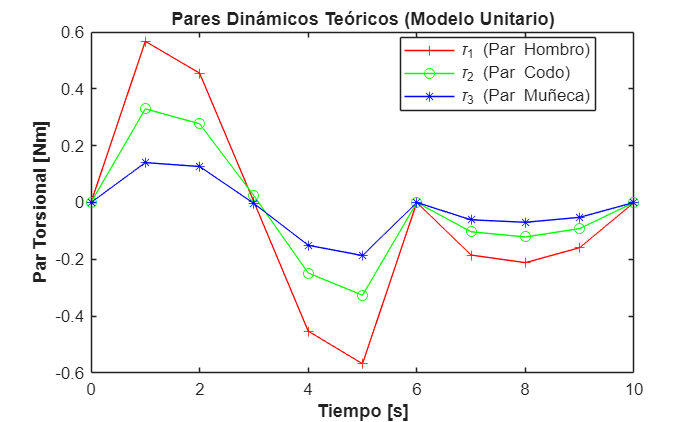

In [14]:
figure;
plot(tsim, tao_1_c, 'r-+');
hold on;
plot(tsim, tao_2_c, 'g-o');
plot(tsim, tao_3_c, 'b-*');
hold off;

legend({'\tau_1 (Par Hombro)', '\tau_2 (Par Codo)', '\tau_3 (Par Muñeca)'}, ...
    'Location', 'best', 'Interpreter', 'tex', 'FontSize', 10);

title('Pares Dinámicos Teóricos (Modelo Unitario)', 'FontWeight', 'bold', 'FontSize', 11);
xlabel('Tiempo [s]', 'FontWeight', 'bold');
ylabel('Par Torsional [Nm]', 'FontWeight', 'bold');


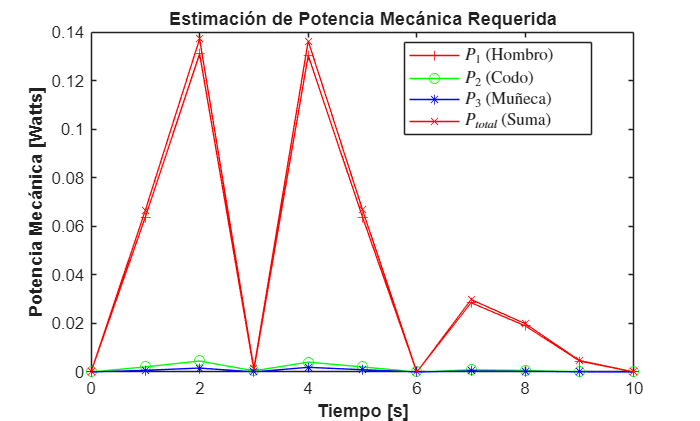

In [15]:
figure;
plot(tsim, pot_1, 'r-+');
hold on;
plot(tsim, pot_2, 'g-o');
plot(tsim, pot_3, 'b-*');
plot(tsim, pot_total, 'r-x');
hold off;

legend({'$P_1$ (Hombro)', '$P_2$ (Codo)', '$P_3$ (Muñeca)', '$P_{total}$ (Suma)'}, ...
    'Location', 'best', 'Interpreter', 'latex', 'FontSize', 10);

title('Estimación de Potencia Mecánica Requerida', 'FontWeight', 'bold', 'FontSize', 11);
xlabel('Tiempo [s]', 'FontWeight', 'bold');
ylabel('Potencia Mecánica [Watts]', 'FontWeight', 'bold');

## Evidencia del funcionamiento

[https://youtu.be/wBSu0r724W8?si=q90SFaI1Eef1ti3C](https://youtu.be/wBSu0r724W8?si=q90SFaI1Eef1ti3C)

## Conclusiones
### Cabrera Cruz Carlo Alejandro

Durante el desarrollo de este proyecto pude comprender mejor la relación entre la teoría de cinemática y  su implementación práctica en un entorno de simulación. Ver el comportamiento del SCARA siguiendo la trayectoria planificada me ayudó a identificar la importancia de respetar tanto las restricciones cinemáticas como la manipulabilidad del robot. Considero que esta experiencia me acercó más al trabajo real en robótica y me dio mayor seguridad para seguir estudiando sistemas mecatrónicos avanzados.

### Gutiérrez Espriella Moisés Ariel

El desarrollo de este proyecto permitió evaluar de manera integral las capacidades cinemáticas y dinámicas de un robot SCARA, cumpliendo satisfactoriamente con el objetivo de diseñar y validar una tarea de manipulación compleja.


En primer lugar, se comprobó la hipótesis planteada: es posible predecir con alta fidelidad el comportamiento físico de un robot mediante un modelado matemático riguroso. La comparación entre los resultados teóricos (obtenidos en MATLAB) y la respuesta experimental (simulada en Gazebo) mostró una correlación directa, especialmente en los perfiles de posición y velocidad. Esto valida no solo el algoritmo de cinemática inversa implementado, sino también la arquitectura de control desarrollada en ROS 2.


El diseño de la trayectoria transversal diagonal demostró ser una estrategia eficaz para evaluar la coordinación multi\-articular. El análisis del Índice de Manipulabilidad confirmó que la ruta seleccionada se mantiene dentro de una zona de trabajo segura, lejos de singularidades mecánicas, lo cual es crítico para garantizar la operabilidad del robot en entornos industriales. Además, la implementación del perfil de velocidad polinómico de quinto grado probó ser fundamental para lograr movimientos suaves, eliminando discontinuidades en la aceleración que podrían generar desgaste prematuro en los actuadores1.


Un hallazgo importante durante la validación experimental fue la presencia de ligeras oscilaciones al finalizar la trayectoria. Esto pone de manifiesto las limitaciones de un controlador cinemático simple (basado solo en posición) frente a la dinámica inercial del sistema. Este fenómeno sugiere que, para aplicaciones de alta velocidad o precisión, sería necesario evolucionar hacia esquemas de control dinámico (como el *Computed Torque Control*) que compensen activamente las fuerzas inerciales y de fricción.


Finalmente, el análisis de potencia mecánica teórica proporcionó criterios cuantitativos para el dimensionamiento energético del sistema3. Se observó cómo el requerimiento de potencia no es lineal, sino que depende críticamente de la aceleración instantánea, lo que abre la puerta a futuras optimizaciones de trayectoria enfocadas en la eficiencia energética. En conclusión, el prototipo virtual desarrollado constituye una plataforma robusta para el diseño y validación de tareas robóticas antes de su implementación física.

### González Martínez Roberto Carlos

A través de este proyecto pude ver de manera clara cómo la teoría de manipulabilidad se relaciona directamente con el desempeño real del robot. Resolver la cinemática inversa y observar cómo respondía el SCARA en el simulador me permitió comprender mejor las limitaciones del sistema y la importancia de planear trayectorias eficientes. Este aprendizaje me motiva a seguir profundizando en temas de control y robótica aplicada.

### Rodriguez Torres Angel Adrian

Para mí este proyecto fue una oportunidad valiosa para consolidar conocimientos de cinemática, simulación y control. Implementar la trayectoria tipo bang\-bang y analizar su efecto en la manipulabilidad del robot me hizo entender de forma más práctica cómo se toma decisiones en la robótica real. Además, trabajar con ROS y Python me ayudó a mejorar mis habilidades técnicas. En general, considero que este proyecto fortaleció mi formación como ingeniero mecatrónico.

## Referencias

**Material de Clase y Diapositivas:**

-  Peña Medina, E. (2023). *Clase 6: Conceptos básicos y elemento base* \[Diapositivas de PowerPoint\]. Facultad de Ingeniería, UNAM.
-  Peña Medina, E. (2023). *Clase 7: Modelo cinemático de la posición* \[Diapositivas de PowerPoint\]. Facultad de Ingeniería, UNAM.
-  Peña Medina, E. (2023). *Clase 8: Planteamiento del modelo dinámico Eüler\-Lagrange* \[Diapositivas de PowerPoint\]. Facultad de Ingeniería, UNAM.
-  Peña Medina, E. (2023). *Clase 9: Planteamiento dinámico Newton\-Eüler y Simulación* \[Diapositivas de PowerPoint\]. Facultad de Ingeniería, UNAM.
-  Peña Medina, E. (2023). *Clase 12: Modelo dinámico de un robot serial RRR* \[Diapositivas de PowerPoint\]. Facultad de Ingeniería, UNAM.
-  Peña Medina, E. (2023). *Clase 13: Propagación de velocidades y cálculo de pares* \[Diapositivas de PowerPoint\]. Facultad de Ingeniería, UNAM.

**Clases en Video (YouTube):**

-  Peña Medina, E. \[Erik Peña Medina\]. (2025, 15 de noviembre). *Clase\_14\_11\_2025* \[Video\]. YouTube. [https://www.youtube.com/watch?v=NI\_pM\-ersRI](https://www.youtube.com/watch?v=NI_pM-ersRI)
-  Peña Medina, E. \[Erik Peña Medina\]. (2025, 19 de noviembre). *Clase\_19\_11\_2025* \[Video\]. YouTube. [https://www.youtube.com/watch?v=JEQb5WL\_\-Ww](https://www.youtube.com/watch?v=JEQb5WL_-Ww)
-  Peña Medina, E. \[Erik Peña Medina\]. (2025, 22 de noviembre). *Clase\_21\_11\_2025* \[Video\]. YouTube. [https://www.youtube.com/watch?v=8Zgj7VhKotU](https://www.youtube.com/watch?v=8Zgj7VhKotU)
-  Peña Medina, E. \[Erik Peña Medina\]. (2025, 24 de noviembre). *Clase\_24\_11\_2025* \[Video\]. YouTube. [https://www.youtube.com/watch?v=\-P7Cq5N55JA](https://www.youtube.com/watch?v=-P7Cq5N55JA)

**Repositorios de Software:**

-  arrg\-mx. (s.f.). *Papime\_PE110923\_rserial: Repositorio de prácticas de robótica serial* \[Repositorio de código\]. GitHub. [https://github.com/arrg\-mx/Papime\_PE110923\_rserial](https://www.google.com/search?q=https://github.com/arrg-mx/Papime_PE110923_rserial)
-  arrg\-mx. (s.f.). *robotica\_2026\-1: Material del curso de Robótica 2026\-1* \[Repositorio de código\]. GitHub. [https://github.com/arrg\-mx/robotica\_2026\-1](https://www.google.com/search?q=https://github.com/arrg-mx/robotica_2026-1)
